# Step by step t-SNE from scratch #

- Load required modules to perform computations and to get dataset. 
- Note that this code illustration is just for the purpose of presenting our understanding. The written here is not perfectly optimized and has a horrible running time, hence to generate better visualisation of results to show the capability of this algorithm, we would use the external library.  
- Though there is a TSNE library under sklearn API which provides us an easy way to generate output and run the algorithm, but here we load this module just for data loading purpose. We will include the results generated from TSNE module as well in the later part to show the output and visualisation. 

In [1]:
import numpy as np 
import time 

#load dataset 
import sklearn 
from sklearn.datasets import fetch_openml

- Load dataset from sklearn API and here we are using MNIST dataset. 
- The dataset consists of 70000 images of handwritten digit. Each of them has 28*28 pixels and its stored in numpy array form (take it as a matrix).
- For image data, think of the entries of the matrix as pixels. And each pixel's value constitutes to magnitude of some colours. 

In [2]:
start = time.time()
X= sklearn.datasets.fetch_openml('mnist_784', as_frame=False, return_X_y=False)
print(X.data.shape) # rows represent the examples whereas columns represent the features (pixels).
end = time.time()
print(end - start) 

c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
44.20841312408447


- Let's start our model from here. 
- The first task is to calculate the conditional probability of point $X_i$ having point $X_j$ as its neighbour. 
- In our report, we have explained how it works. 
- The following function takes in two points to calculate the euclidean distance between the points.  

In [3]:
def calc_dist(x_i, x_j):
    '''
    Arguments:
    x_i ,x_j: should be numpy array that represents the examples of the datasets. 
    Length of the vectors is equal to the number of columns of the data matrix. 
    '''
    sum = np.linalg.norm(x_i - x_j)
    return sum

- The main function to compute the $P_{j|i}$ conditional probability.  
- This is the conditional probability of $X_{i}$ having $X_{j}$ as its neighbour.
- How it works is through fitting a gaussian density to point i and if point j happens to be in the contour of it then the output of the computation would be the probability.
- The size of the contour is depending on the magnitude of perplexity. As the sigmas increase monotonically as the perplexity, thus a high perplexity would mean a larger contour.  

In [4]:
def compute_Pji(X, sigmas):
    '''
    Arguments:
    X : should be a numpy array whose row is example and column is feature
    passing each example thru passing in X[i] for i = 0, ... n-1. (python index starts with 0)
    
    sigmas: need to be computed from other function according to some perplexity
    should be an arrray since we cannot assume sigma is constant acorss all points
    but the length of sigma must be same as number of rows of X
    '''
    dimX_row = X.shape[0] # number of example
    dimX_col= X.shape[1]
    pji = np.zeros((dimX_row, dimX_row)) # should be a square matrix of which diagonal entries are zeros
    total = 0

    if sigmas is not None: 
        for i in range(dimX_row): #condition points 
            for j in range(dimX_row): #variation point
                if i != j:
                    pji[i][j] = -calc_dist(X[i][0:dimX_col-1], X[j][0:dimX_col-1]) 
                    pji[i][j] = pji[i][j]/(2*sigmas[i]**2)
                    pji[i][j] = np.exp(pji[i][j])
                    #output of pji: p[i][j] = prob of point j given point i
                else:  
                    pji[i][j] = float(10**(-8)) # for numerical stability, to compute log after this
                total = total + pji[i][j] #diagonal is zero so sum of all entries is less complicated
    else: 
        return None

    pji = pji/total # total is scalar 

    return pji #matrix of probability, each entry represents the probability of point j being a neighbour of point i 

- Here is the function for the computation of perplexity.
- Perplexity is a smooth measure of number of neighbours. 
- Sum horizontally acorss the probability matrix as the matrix structure is such that each row represents an array of which each array is prob point j conditioning point i. 

In [5]:
def calc_perplex(pji): #pji is the prob matrix 
    '''
    Arguments: 
    pji : should be the output from the function compute_Pji. 

    Return:
    perplex: a vector in np.array format
    '''
    dim_row_pji = pji.shape[0]
    dim_col_pji = pji.shape[1]
    entropy = np.zeros((dim_row_pji, dim_col_pji))

    for i in range(dim_row_pji):
        for j in range(dim_col_pji):
            if pji[i][j] != 0:
                entropy[i][j] = pji[i][j] * np.log2(pji[i][j])
            else:
                entropy[i][j] = 10**-100 #for numerical stability
            
    # print(entropy) 
    # print(entropy.shape)
    entropy = - np.sum(entropy, axis=1) # sum horizontally
    perplex = 2**entropy
    
    return perplex #output vector: perplex of each i 

def perplexity(X, sigmas):
    return calc_perplex(compute_Pji(X, sigmas)) # for simplicity. 

#### Binary search operation to find the optimal sigma values for each i. 
- This is a rather complicated operation, thus a more detailed explaination is provided, as follows:
- We have to manually select a perplexity value normally it is between 5 to 50. Intuitively speaking, it simply means a knob that sets the number of effective nearest neighbours. 
- To compute the best set of sigmas, we use bianry search. 
- How the binary search works here is that it takes in input of a sorted array which an upper bound and lower bound and a target whose value is what we want to compare with our output of some computation in our binary search at each iteration. The searching processs is done recusively through iteratively spliting the input array into half and compare the the target with the ending of left subarray and the starting values of the right subarray. We only make two comparison at every iteration becuase the array we are splitting is a sorted array. 
- The program terminates here becuase we define a maximum of number of iterations using for loop. So, the output would either be close to the actual value we want to find which is rather less likely, or the algorithm has reached to its max iteration limit. 

In [6]:
def binarySearch_forOptSigmas(X, sigmas, targeted_Perplexity, threshold=1e-20, max_iter=100000, lower=1e-20, upper=1000.):
    '''
    Arguments:
    X: numpy array that represents the data matrix
    sigmas: randomly initiate some sigmas, it would be replaced and will not be taken into the computation 
    targeted_Perplexity: an integer being set manually 
    '''

    for j in range(X.shape[0]):   #for each example

        for i in range(max_iter): # recursive algorithm

            guess = (lower + upper) / 2 

            sigmas[j] = guess # middle of the bound 

            val = perplexity(X, sigmas)[j] #calculate the perplexity

            if val > targeted_Perplexity: 
                upper = guess #ignore another half of the array of bound if the condition is met and vise versa

            else:
                lower = guess

            if np.abs(val - targeted_Perplexity) <= threshold: #of little likelihood that we can find an actual value, hence as long as lower than a threshold, good enough
               break

        #print(sigmas[j])
    
    return sigmas

- Making the $P_{j|i}$ symmetric

In [7]:
def symmetricPij(X,sigmas):
    '''
    Arguments: 
    X, sigmas: similar as before. 
    '''
    n = X.shape[0]
    P = compute_Pji(X,sigmas)
    PT = P.T # transpose
    P = (P+PT)/2*n #make it symmetric
    
    return P

- Compute $q_{j|i}$

In [8]:
def compute_Qji(Y):
    '''
    Arguments: 
    Y: a matrix being stored in numpy array format. 
    whose row's number is the same as data matrix X and column's number is set manually depending on the desired dimensionality of space we want to embed onto.  
    '''
    
    dim_Y = Y.shape[0]
    q_ji = np.zeros((dim_Y,dim_Y))
    total = 0

    for i in range(dim_Y):
        for j in range(dim_Y):
            dums = 1+(np.linalg.norm(Y[i][0:Y.shape[1]-1]- Y[j][0:Y.shape[1]-1]))#formula given in report
            dums = dums*dums
            dums = 1/dums
            q_ji[i][j] = dums
            total = total + dums
            
    q_ji = q_ji/total 
    
    return q_ji

- Compute Kullback Leibler divergence.
- KL divergence is a measure of how the probability distribution p is different from a second, reference probability distribution q.
- of which p is derived from computing distance between points in the original space whereas q is derived from distance between points in embedded space. 
- Hence, one could think it as to measure the loss of information during the embedding process. 
- No doubt that we want to minimise the loss of information and we want to find a q such that q preserves as much information as possible as in the original space. 

In [9]:
def KL_divergence(Y, symP):
    '''
    Arguments:
    Y: the data matrix represents the embedded points in the low dimensional space
    symP: the output from symmetricPij function which represents the the symmetric conditional pji matrix. 
    
    '''
    q_ji = compute_Qji(Y)
    dim_i = symP.shape[0]
    total = 0
    for i in range(dim_i):
        for j in range(dim_i):
            total = total + symP[i][j]*np.log(symP[i][j]/ q_ji[i][j]) #formula given in report
    
    return total

- Recall that the parameters we want to estimate through gradient descent here are the matrix Y. 
- Y represents the points in the embedded space. Therefore, we set it to have number of columns as 2.
- For the mathematical details, please visit section 2.2 Gradient descent in our report.  
- This is also where everything being put together and matric Y is being learned. 
- Alert: Extremely long running time hence be careful of the input data size. 

In [10]:
def gradient_C_yi(X, Epochs=100, dim_y=2, targeted_Perplexity=30, learning_Rate=0.1, momentum=0.8):
    '''
    Arguments:
    matY: in format of np.array and which represents the embedded space
    Epochs: in format of integer - represents number of epochs - which means the number of times of all training data passing through the model. 
    X: in format of np.array and represents the input data matrix
    sigmas: in format of np.array - a vector represents sigmas. simply initialise some random values as they wouldnt be taken into computation
    learning_Rate: in format of integer
    momentum: in format of integer, to be tuned manually, for mnist data, recommended to be between 0.8 to 1.2
    dim_y: in format of integer, represent the dimension of embedded space, normally it is 2 or 3. 
    Cautious: too low values of learning rate, momentum and too high value of epochs, dim_y would result in extremely high running time   
    '''
    
    sigmas = np.ones(X.shape[0]) #not important, initialisation purpose
    n = X.shape[0] #n shoul dbe the same for x and y matrices they both have same number of rows
    initiateY = np.random.normal(0, 10**-4, size=(n, dim_y))
    sum_total = np.zeros((n,initiateY.shape[1]))
    past_value = np.zeros((initiateY.shape[0],dim_y,2))
    qij = compute_Qji(initiateY)
    sigmas = binarySearch_forOptSigmas(X, sigmas, targeted_Perplexity)
    pij = symmetricPij(X, sigmas)

    for iter in range(Epochs):
        for i in range(n):
            for j in range(n):
                sum_total[i][:] = sum_total[i][:] + 4*(initiateY[i][:] - initiateY[j][:])*(pij[i][j] - qij[i][j])*((1+np.linalg.norm(initiateY[i]-initiateY[j])**2)**-1)
                past_value[i][0][:] = past_value[i][1][:]
                past_value[i][1][:] = initiateY[i][:]
                initiateY[i][:] = initiateY[i][:] + learning_Rate*sum_total[i][:] + momentum*(past_value[i][1] - past_value[i][0])

        # if iter%100==0:
        #     print(KL_divergence(pij,qij)) 

    return initiateY

- 2 data points take 10 seconds to run. let alone 70k. 

In [11]:
begin = time.time()
datatotest = X.data[0:5, :] #take a subset of the whole data matrix for testing purpose. 
test1 = gradient_C_yi(Epochs=200, dim_y= 2, X=datatotest, learning_Rate=0.1, momentum=0.8, targeted_Perplexity=30)
print(test1)
print(test1.shape)
end = time.time()
print("total running time: " + str(end - begin)) 

[[  595.66943936  1803.69144125]
 [ -311.57048205 -2027.4488051 ]
 [ 1405.61004348  -159.17334497]
 [-1558.229377     546.75912334]
 [ -229.62539572  -391.39826156]]
(5, 2)
total running time: 202.3049557209015


- The following are codes to generate visualisation. 

In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.express as px
%matplotlib inline
import seaborn as sns
import MulticoreTSNE
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.decomposition import KernelPCA
import umap.umap_ as umap
import tensorflow as tf

c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWa

In [30]:
# Load the MNIST data
%time X2 = fetch_openml('mnist_784')
test_X_2 = X2.data 
test_Y_2 = X2.target

c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


CPU times: total: 56.4 s
Wall time: 1min 3s


CPU times: total: 3min 57s
Wall time: 2min 12s


c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


[Text(0.5, 1.0, 'UMAP on MNIST dataset')]

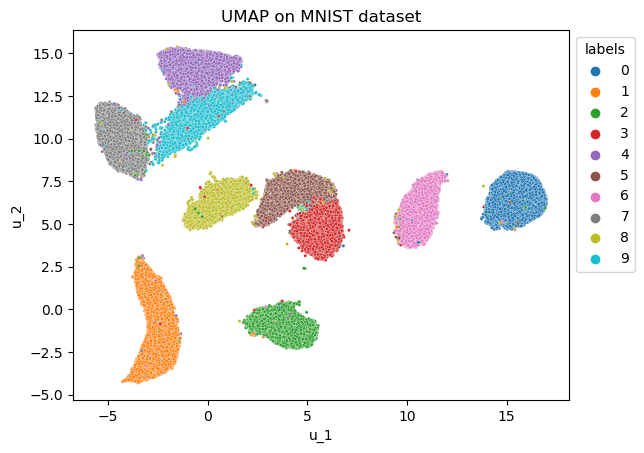

In [31]:
fit_umap = umap.UMAP(n_neighbors=15, random_state=42, metric='euclidean')
%time u = fit_umap.fit_transform(test_X_2)
output0 = pd.DataFrame(u, columns=('u_1','u_2'))
output0['labels'] = test_Y_2
ax = sns.scatterplot(data = output0, x = 'u_1', y = 'u_2', hue = 'labels', cmap="Spectral", s=5, legend = 'full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='UMAP on MNIST dataset')

CPU times: total: 35min 1s
Wall time: 21min 37s


c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


[Text(0.5, 1.0, 't-SNE on MNIST dataset')]

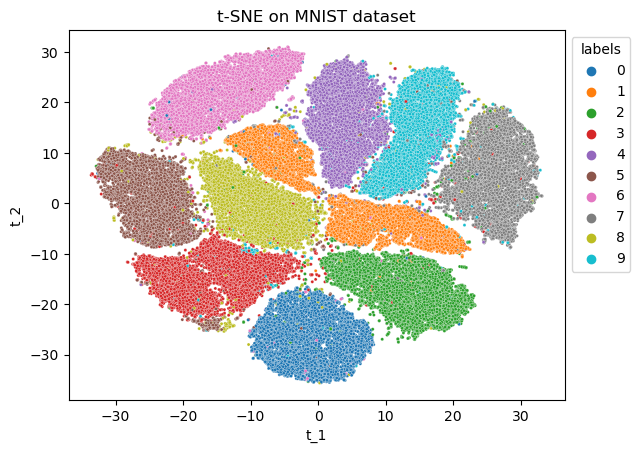

In [32]:
fit_tsne = MulticoreTSNE.MulticoreTSNE(n_jobs=2, random_state=42) #parallel computing
%time t = fit_tsne.fit_transform(test_X_2)
output1 = pd.DataFrame(t, columns=('t_1','t_2'))
output1['labels'] = test_Y_2
ax = sns.scatterplot(data = output1, x='t_1',y='t_2', hue='labels', cmap="Spectral", s=5, legend = 'full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='t-SNE on MNIST dataset')

CPU times: total: 8.69 s
Wall time: 4.58 s


c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


[Text(0.5, 1.0, 'Kernel PCA on MNIST dataset')]

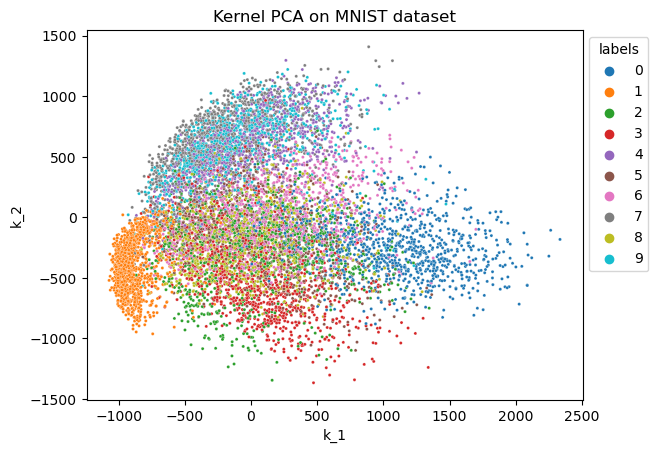

In [33]:
fit_KPCA = KernelPCA(n_components=2, kernel='linear')
%time k = fit_KPCA.fit_transform(test_X_2[0:10000])
output2 = pd.DataFrame(k, columns=('k_1','k_2'))
output2['labels'] = test_Y_2
ax = sns.scatterplot(data = output2, x='k_1',y='k_2', hue='labels', cmap="Spectral", s=5, legend = 'full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='Kernel PCA on MNIST dataset')

In [34]:
fit_KPCA_2 = KernelPCA(n_components=3, kernel='linear')
%time k2 = fit_KPCA_2.fit_transform(test_X_2[0:5000])
output2k = pd.DataFrame(k2, columns=('k_1','k_2','k_3'))
output2k['labels'] = test_Y_2[0:5000]
fig = px.scatter_3d(output2k, x='k_1', y='k_2', z='k_3',
    color='labels', labels={'color': 'labels'})
fig.update_traces(marker_size=3)
fig.show()

CPU times: total: 2.67 s
Wall time: 1.12 s


CPU times: total: 26.2 s
Wall time: 12.9 s


c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\seaborn\relational.py:573: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



[Text(0.5, 1.0, 'Eigen Maps on MNIST dataset')]

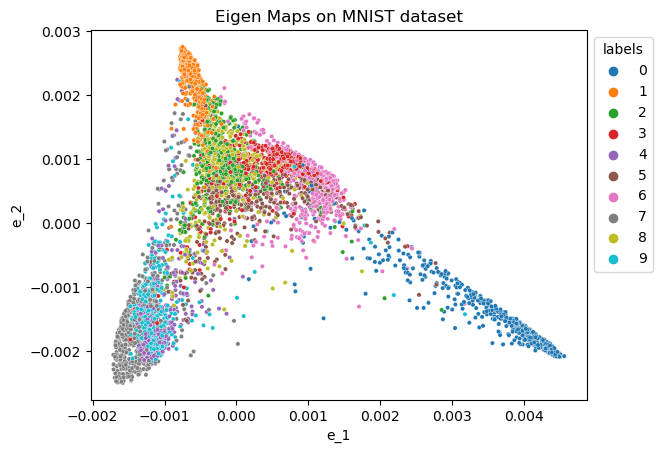

In [35]:
fit_eigenmaps = SpectralEmbedding(n_neighbors=100)
%time e = fit_eigenmaps.fit_transform(test_X_2[0:5000])
output3 = pd.DataFrame(e, columns=('e_1','e_2'))
output3['labels'] = test_Y_2[0:5000]
ax = sns.scatterplot(data = output3, x='e_1',y='e_2', hue='labels', cmap="Spectral", s=10, legend = 'full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='Eigen Maps on MNIST dataset')

CPU times: total: 31 s
Wall time: 35.1 s


c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\seaborn\relational.py:573: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



[Text(0.5, 1.0, 'Isomap on MNIST dataset')]

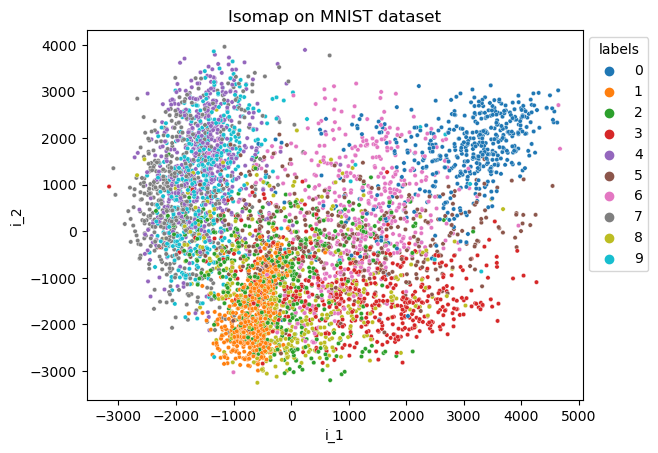

In [36]:
fit_Isomap = Isomap(n_neighbors=50)
%time i = fit_Isomap.fit_transform(test_X_2[0:5000])
output4 = pd.DataFrame(i, columns=('i_1','i_2'))
output4['labels'] = test_Y_2[0:5000]
ax = sns.scatterplot(data = output4, x='i_1',y='i_2', hue='labels', cmap="Spectral", s=10, legend = 'full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='Isomap on MNIST dataset')

CPU times: total: 1min 14s
Wall time: 22.7 s


c:\Users\Anaconda3\envs\msc_cwork\lib\site-packages\seaborn\relational.py:573: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



[Text(0.5, 1.0, 'Locally Linear Embedding on MNIST dataset')]

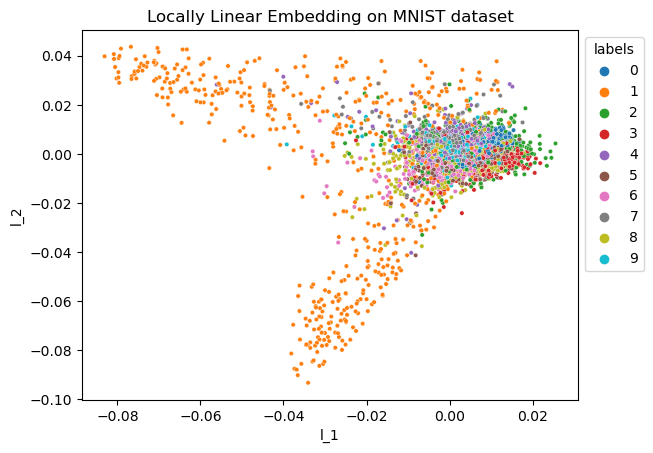

In [37]:
fit_LLE = LocallyLinearEmbedding(n_neighbors=200)
%time l = fit_LLE.fit_transform(test_X_2[0:5000])
output5 = pd.DataFrame(l, columns=('l_1','l_2'))
output5['labels'] = test_Y_2
ax = sns.scatterplot(data = output5, x='l_1',y='l_2', hue='labels', cmap="Spectral", s=10, legend = 'full')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(title='Locally Linear Embedding on MNIST dataset')